In [1]:
import sys
sys.path.insert(0, "..")

import views_utils.dbutils as dbutils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
prefix = "postgresql"
uname = "VIEWSADMIN"
db = "views"
port = "5432"
hostname = "VIEWSHOST"
connectstring = dbutils.make_connectstring(prefix, db, uname, hostname, port)
print(connectstring)

postgresql://VIEWSADMIN@VIEWSHOST:5432/views


In [3]:
table = "country"
schema = "staging"
columns = ['id', 'name']
df_cnames = dbutils.db_to_df(connectstring, schema, table, columns)
df_cnames.rename(columns={'id' : 'country_id'}, inplace=True)
print(df_cnames.head())
df_cnames.set_index(['country_id'], inplace=True)

Connecting to postgresql://VIEWSADMIN@VIEWSHOST:5432/views using sqlalchemy ...  [OK] 
Getting 2 cols from  staging.country  from  postgresql://VIEWSADMIN@VIEWSHOST:5432/views ...  [OK] 
runtime:  0.12739896774291992 rows:  255 rows/seconds:  2001.5860765415925
   country_id                 name
0           1               Guyana
1           2             Suriname
2           3  Trinidad and Tobago
3           4            Venezuela
4           5                Samoa


/Users/VIEWSADMIN/miniconda3/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:2543: SAWarning: Did not recognize type 'geometry' of column 'geom'
  (attype, name))


In [4]:
table = "country_year"
schema = "staging"
timevar = "year_id"
groupvar = "country_id"
columns = ["country_id", "year_id", "fvp_conflict", "fvp_lngdp200", "fvp_lngdppercapita200"]
tmin = 1980
tmax = 2100

df = dbutils.db_to_df_limited(
        connectstring = connectstring, 
        schema   = schema, 
        table    = table,
        columns  = columns,
        timevar  = timevar,
        groupvar = groupvar,
        tmin     = tmin, 
        tmax     = tmax
        )

Getting 5 cols from staging.country_year ...  [OK] 
runtime:  0.393312931060791 rows:  23260 rows/seconds:  59138.66075357919


In [5]:
df = df.merge(df_cnames, left_index=True, right_index=True)

In [6]:
name_sourcevar = "fvp_lngdppercapita200"
name_var = "lngdppercapita"
# drop those missing GDP and rename
df = df.drop(df[df[name_sourcevar].isnull()].index)
#df = df[pd.notnull(df[name_sourcevar])]
df.rename(columns={name_sourcevar : name_var}, inplace=True)
df_clean = df.copy()

.........1990
.........2000
.........2010
.........2020
.........2030
.........2040
.........2050
.........2060
.........2070
.........2080
.........2090
.........2100


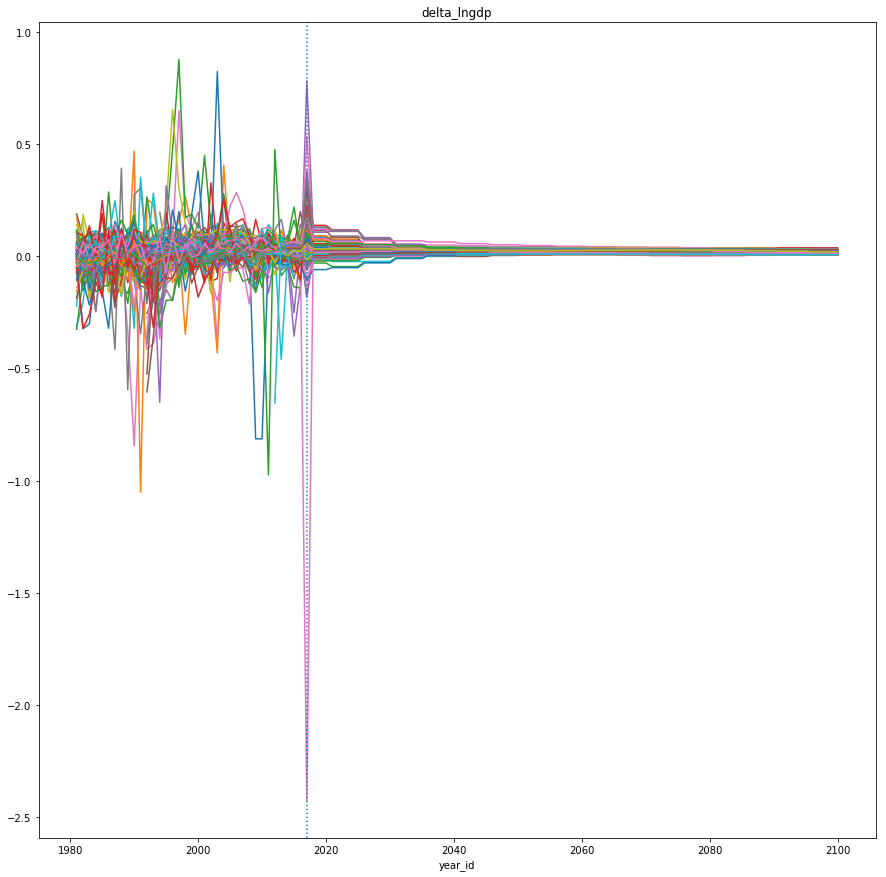

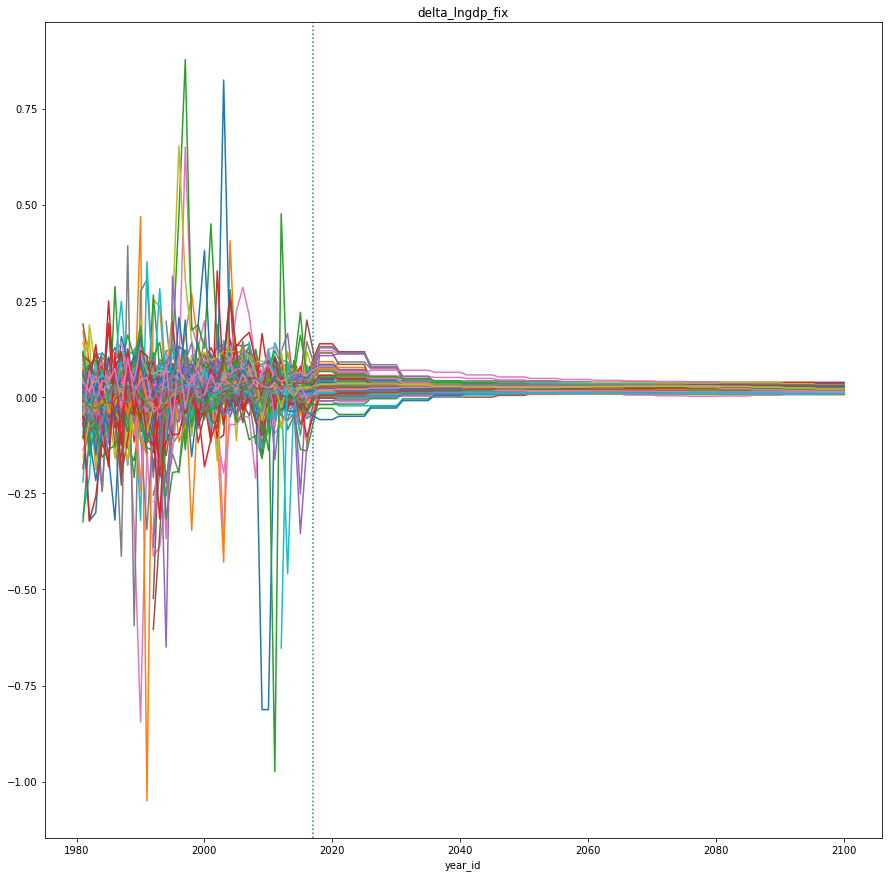

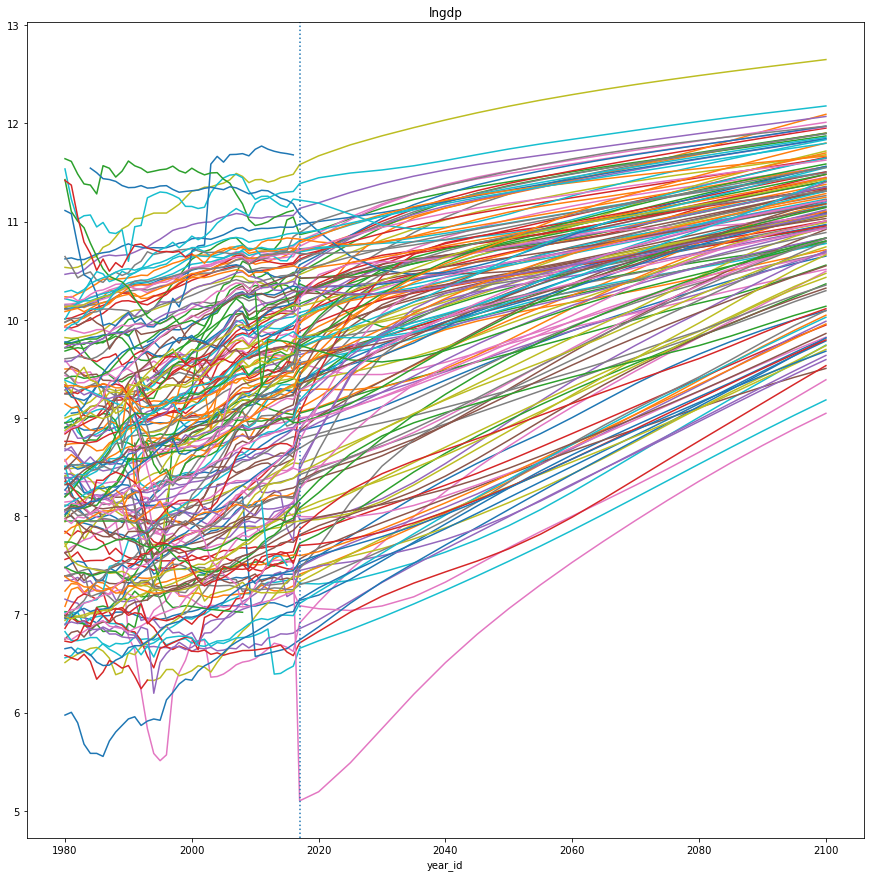

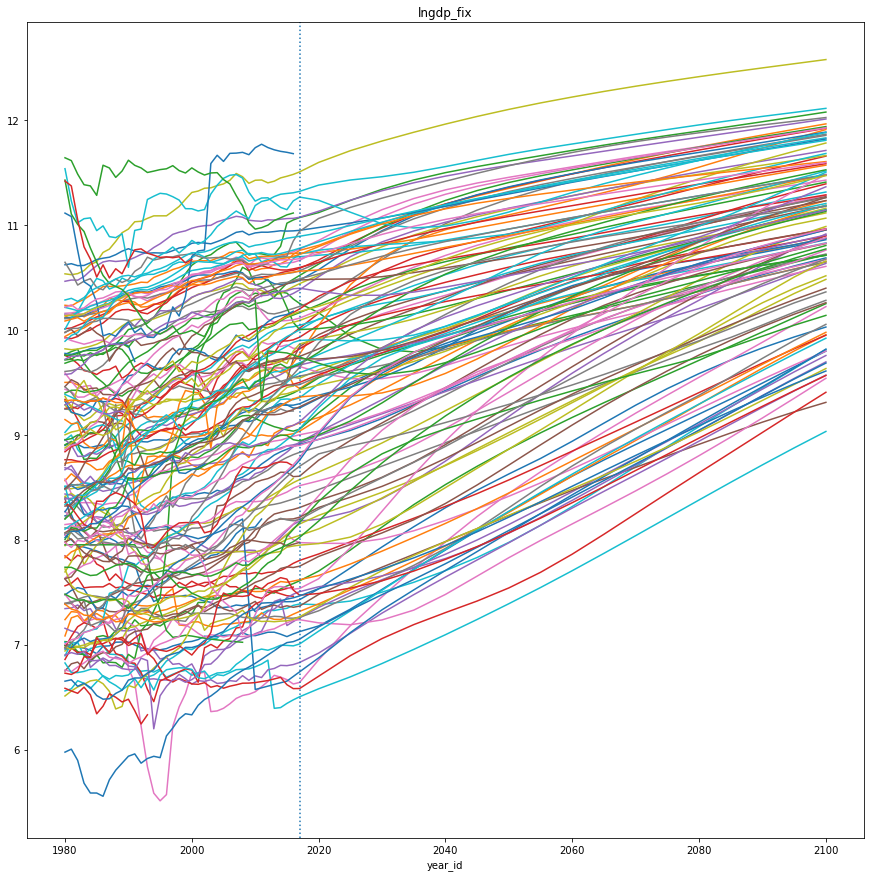

In [7]:
def smooth_blip(df, name_var, t_blip, plots_show=True):
    
    df.sort_index(inplace=True)

    name_lag = "l1_" + name_var
    name_delta = "delta_" + name_var
    name_var_fix = name_var + "_fix"
    name_delta_fix = name_delta + "_fix"
    name_lag_fix = name_lag + "_fix"

    times = sorted(list(set(df.index.get_level_values(level=0))))
    start = times[0]
    #start = t_blip - 2
    
    # init empty columns
    df[name_var_fix] = np.nan
    df[name_lag_fix] = np.nan
    
    # compute delta
    lag = 1
    df[name_lag] = (df.groupby(level=1)[name_var].shift(lag))
    df[name_delta] = df[name_var] - df[name_lag]
    
    # drop broken year from deltas and interpolate over it
    df[name_delta_fix] = df[name_delta]
    df.loc[t_blip, name_delta_fix] = np.nan
    df[name_delta_fix] = df[name_delta_fix].groupby(level=1).apply(lambda group: group.interpolate(method='linear'))
        
    df.loc[(start,slice(None)), name_var_fix] = df.loc[(start,slice(None)), name_var]
    
    # From the second t with data for each year
    for t in times[1:]:
    #for t in times[start+1:]:
        if t%10==0:
            print(t)
        else:
            print(".", end="")
            
        # compute the fixed lag as the lag of the fixed variable
        #df.loc[t][name_lag_fix] = (df.groupby(level=1)[name_var_fix].shift(lag)).loc[t]
        df.loc[(t, slice(None)), name_lag_fix] = (df.groupby(level=1)[name_var_fix].shift(lag)).loc[t].values
        # compute var_fix = lag_fix + delta_fix
        #df.loc[t][name_var_fix] = df.loc[t][name_lag_fix] + df.loc[t][name_delta_fix]
        df.loc[(t, slice(None)), name_var_fix] = df.loc[(t, slice(None)), name_lag_fix] + df.loc[(t, slice(None)), name_delta_fix]
    
        
    if plots_show:
        country_ids = list(set(df.index.get_level_values(1)))
        plt.figure(figsize=(15,15))
        plt.title(name_delta)
        for cid in country_ids:
            df.xs(cid, level=1)[name_delta].plot()
        plt.axvline(t_blip, linestyle='dotted')
        plt.show()

        country_ids = list(set(df.index.get_level_values(1)))
        plt.figure(figsize=(15,15))
        plt.title(name_delta_fix)
        for cid in country_ids:
            df.xs(cid, level=1)[name_delta_fix].plot()
        plt.axvline(t_blip, linestyle='dotted')
        plt.show()

        country_ids = list(set(df.index.get_level_values(1)))
        plt.figure(figsize=(15,15))
        plt.title(name_var)
        for cid in country_ids:
            df.xs(cid, level=1)[name_var].plot()
        plt.axvline(t_blip, linestyle='dotted')
        plt.show()

        country_ids = list(set(df.index.get_level_values(1)))
        plt.figure(figsize=(15,15))
        plt.title(name_var_fix)
        for cid in country_ids:
            df.xs(cid, level=1)[name_var_fix].plot()
        plt.axvline(t_blip, linestyle='dotted')
        plt.show()
    
    df[name_var] = df[name_var_fix]
    df.drop(columns=[name_delta, name_var_fix, name_delta, name_delta_fix], inplace=True)
    
    return df
df = df_clean.copy()
df = smooth_blip(df, name_var, 2017)